# Roadside Monocular 3D Detection Prompted by 2D Detection

This Jupyter Notebook runs our Pro3D (w/ BEVHeight) for roadside monocular 3D detection. It displays visual results overlaid on images and BEV view of LiDAR point clouds.


## Cell 0: Add Project Path

In [6]:
import sys
sys.path.append('./Pro3D')

## Cell 1: configure Arguments

In [7]:
from argparse import Namespace

infer_args = Namespace(
    gpus=1,
    batch_size_per_device=1,
    evaluate=True,
    seed=42,
    ckpt_path='checkpoints/pro3d_101_bev-light.ckpt',
    profiler='simple',
    deterministic=False,
    max_epochs=60,
    accelerator='gpu',
    num_sanity_val_steps=0,
    gradient_clip_val=5,
    limit_val_batches=0,
    enable_checkpointing=True,
    precision=32,
    default_root_dir='./outputs/pro3d_infer_outputs',
)

## Cell 2: Define the proposed Pro3D model

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import mmcv
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn.parallel
import torch.utils.data
import torchvision.models as models
from pytorch_lightning.core import LightningModule
from torch.optim.lr_scheduler import MultiStepLR

from dataset.nusc_mv_det_dataset import NuscMVDetDataset, collate_fn
from evaluators.det_evaluators import RoadSideEvaluator
from models.pro3d import Pro3D
from utils.torch_dist import all_gather_object, get_rank, synchronize


H = 1080
W = 1920
final_dim = (864, 1536)
img_conf = dict(img_mean=[123.675, 116.28, 103.53],
                img_std=[58.395, 57.12, 57.375],
                to_rgb=True)

data_root = "data/dair-v2x-i/"
gt_label_path = "data/dair-v2x-i-kitti/label_2"

backbone_conf = {
    'x_bound': [0, 102.4, 0.4],
    'y_bound': [-51.2, 51.2, 0.4],
    'z_bound': [-5, 3, 8],
    'd_bound': [-2.0, 0.0, 90],
    'final_dim': final_dim,
    'output_channels': 80,
    'downsample_factor': 16,
    'img_backbone_conf': dict(
        type='ResNet',
        depth=101,
        frozen_stages=0,
        out_indices=[0, 1, 2, 3],
        norm_eval=False,
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet101'),
    ),
    'img_neck_conf': dict(
        type='SECONDFPN',
        in_channels=[256, 512, 1024, 2048],
        upsample_strides=[0.25, 0.5, 1, 2],
        out_channels=[128, 128, 128, 128],
    ),
    'height_net_conf': dict(in_channels=512, mid_channels=512)
}

ida_aug_conf = {
    'final_dim': final_dim,
    'H': H,
    'W': W,
    'bot_pct_lim': (0.0, 0.0),
    'cams': ['CAM_FRONT'],
    'Ncams': 1,
}

bev_backbone = dict(
    type='ResNet',
    in_channels=80,
    depth=18,
    num_stages=3,
    strides=(1, 2, 2),
    dilations=(1, 1, 1),
    out_indices=[0, 1, 2],
    norm_eval=False,
    base_channels=160,
)

bev_neck = dict(type='SECONDFPN',
                in_channels=[80],
                upsample_strides=[1],
                out_channels=[256])

CLASSES = ['Vehicle', 'Cyclist', 'Pedestrian']

TASKS = [
    dict(num_class=1, class_names=['Vehicle']),
    dict(num_class=1, class_names=['Cyclist']),
    dict(num_class=1, class_names=['Pedestrian'])
]

common_heads = dict(reg=(2, 2), height=(1, 2), dim=(3, 2), rot=(2, 2), vel=(2, 2))

bbox_coder = dict(
    type='CenterPointBBoxCoder',
    post_center_range=[0, -51.2, -5, 102.4, 51.2, 3],
    max_num=500,
    score_threshold=0.1,
    out_size_factor=4,
    voxel_size=[0.1, 0.1, 8],
    pc_range=[0, -51.2, -5, 102.4, 51.2, 3],
    code_size=9,
)

train_cfg = dict(
    point_cloud_range=[0, -51.2, -5, 102.4, 51.2, 3],
    grid_size=[1024, 1024, 1],
    voxel_size=[0.1, 0.1, 8],
    out_size_factor=4,
    dense_reg=1,
    gaussian_overlap=0.1,
    max_objs=500,
    min_radius=2,
    code_weights=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5],
)

test_cfg = dict(
    post_center_limit_range=[0.0, -51.2, -5, 102.4, 51.2, 3],
    max_per_img=500,
    max_pool_nms=False,
    min_radius=[4, 0.85, 0.175],
    score_threshold=0.1,
    out_size_factor=4,
    voxel_size=[0.1, 0.1, 8],
    nms_type='circle',
    pre_max_size=1000,
    post_max_size=83,
    nms_thr=0.2,
)

head_conf = {
    'bev_backbone_conf': bev_backbone,
    'bev_neck_conf': bev_neck,
    'tasks': TASKS,
    'common_heads': common_heads,
    'bbox_coder': bbox_coder,
    'train_cfg': train_cfg,
    'test_cfg': test_cfg,
    'in_channels': 256,
    'loss_cls': dict(type='GaussianFocalLoss', reduction='mean'),
    'loss_bbox': dict(type='L1Loss', reduction='mean', loss_weight=0.25),
    'gaussian_overlap': 0.1,
    'min_radius': 2,
}

class Pro3DLightningModel(LightningModule):
    MODEL_NAMES = sorted(name for name in models.__dict__
                         if name.islower() and not name.startswith('__')
                         and callable(models.__dict__[name]))

    def __init__(self,
                 gpus: int = 1,
                 data_root=data_root,
                 eval_interval=1,
                 batch_size_per_device=8,
                 class_names=CLASSES,
                 backbone_conf=backbone_conf,
                 head_conf=head_conf,
                 ida_aug_conf=ida_aug_conf,
                 default_root_dir='outputs/',
                 **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.gpus = gpus
        self.eval_interval = eval_interval
        self.batch_size_per_device = batch_size_per_device
        self.data_root = data_root
        self.basic_lr_per_img = 2e-4 / 64
        self.class_names = class_names
        self.backbone_conf = backbone_conf
        self.head_conf = head_conf
        self.ida_aug_conf = ida_aug_conf
        mmcv.mkdir_or_exist(default_root_dir)
        self.default_root_dir = default_root_dir
        self.evaluator = RoadSideEvaluator(class_names=self.class_names,
                                           current_classes=["Vehicle", "Pedestrian", "Cyclist"],
                                           data_root=data_root,
                                           gt_label_path=gt_label_path,
                                           output_dir=self.default_root_dir)
        self.model = Pro3D(self.backbone_conf, self.head_conf)
        self.mode = 'valid'
        self.img_conf = img_conf
        self.data_use_cbgs = False
        self.num_sweeps = 1
        self.sweep_idxes = list()
        self.key_idxes = list()
        self.up_stride = 8
        self.downsample_factor = self.backbone_conf['downsample_factor'] // self.up_stride
        self.dbound = self.backbone_conf['d_bound']
        self.height_channels = int(self.dbound[2])

    def forward(self, sweep_imgs, mats):
        return self.model(sweep_imgs, mats)

    def training_step(self, batch):
        (sweep_imgs, mats, _, _, gt_boxes, gt_labels) = batch
        if torch.cuda.is_available():
            for key, value in mats.items():
                if key == 'prompt_2d' or key == 'prompt_class' or key == 'image_mask':
                    mats[key] = [gt_box_2d.cuda() for gt_box_2d in mats[key]]
                else:
                    mats[key] = value.cuda()
            sweep_imgs = sweep_imgs.cuda()
            gt_boxes = [gt_box.cuda() for gt_box in gt_boxes]
            gt_labels = [gt_label.cuda() for gt_label in gt_labels]

            prompt_flag = True
            for gt_box in gt_boxes:
                if gt_box.shape[0] == 0:
                    prompt_flag = False
                    break
            if prompt_flag:     
                batch_size = len(gt_boxes)
                gt_boxes_list = list()
                gt_labels_list = list()
                for i in range(batch_size):
                    for gt_box in gt_boxes[i]:
                        gt_boxes_list.append(gt_box.unsqueeze(0))
                    for gt_label in gt_labels[i]:    
                        gt_labels_list.append(gt_label.unsqueeze(0))
                gt_boxes = gt_boxes_list
                gt_labels = gt_labels_list
        preds = self(sweep_imgs, mats)
        # torch.cuda.empty_cache()
        if isinstance(self.model, torch.nn.parallel.DistributedDataParallel):
            targets = self.model.module.get_targets(gt_boxes, gt_labels)
            detection_loss = self.model.module.loss(targets, preds, mats)
        else:
            targets = self.model.get_targets(gt_boxes, gt_labels)
            detection_loss = self.model.loss(targets, preds)  
        if prompt_flag == False:
            print("Wrong!")
            detection_loss /= 100000
        self.log('detection_loss', detection_loss)
        return detection_loss

    def eval_step(self, batch, batch_idx, prefix: str):
        (sweep_imgs, mats, _, img_metas, gt_boxes, gt_labels) = batch

        img_metas_list = list()
        batch_size = len(mats['prompt_2d'])
        for i in range(batch_size):
            prompt_per_batch_size = mats['prompt_2d'][0].shape[0]
            for j in range(prompt_per_batch_size):
                img_metas_list.append(img_metas[i])
        img_metas = img_metas_list      

        if torch.cuda.is_available():
            for key, value in mats.items():
                if key == 'prompt_2d' or key == 'prompt_class':
                    mats[key] = [gt_box_2d.cuda() for gt_box_2d in mats[key]]
                else:
                    mats[key] = value.cuda()
            sweep_imgs = sweep_imgs.cuda()
        preds = self(sweep_imgs, mats)
        torch.cuda.empty_cache()
        if isinstance(self.model, torch.nn.parallel.DistributedDataParallel):
            results = self.model.module.get_bboxes(preds, img_metas)
        else:
            results = self.model.get_bboxes(preds, img_metas)

        outputs_boxes = list()
        outputs_scores = list()
        outputs_labels = list()
        for i in range(len(results)):
            outputs_boxes.append(results[i][0].tensor.detach().cpu().numpy()[0:1])
            outputs_scores.append(results[i][1].detach().cpu().numpy()[0:1])
            outputs_labels.append(results[i][2].detach().cpu().numpy()[0:1])

        outputs_boxes = np.concatenate(outputs_boxes) 
        outputs_scores = np.concatenate(outputs_scores) 
        outputs_labels = np.concatenate(outputs_labels)   
        results = list()
        result = list()
        result.append(outputs_boxes)
        result.append(outputs_scores)
        result.append(outputs_labels)
        result.append(img_metas[0])
        results.append(result)
            
        return results

    def validation_step(self, batch, batch_idx):
        return self.eval_step(batch, batch_idx, 'val')

    def validation_epoch_end(self, validation_step_outputs):
        all_pred_results = list()
        all_img_metas = list()
        for validation_step_output in validation_step_outputs:
            for i in range(len(validation_step_output)):
                all_pred_results.append(validation_step_output[i][:3])
                all_img_metas.append(validation_step_output[i][3])
        synchronize()
        len_dataset = len(self.val_dataloader().dataset)
        all_pred_results = sum(
            map(list, zip(*all_gather_object(all_pred_results))),
            [])[:len_dataset]
        all_img_metas = sum(map(list, zip(*all_gather_object(all_img_metas))),
                            [])[:len_dataset]
        if get_rank() == 0:
            self.evaluator.evaluate(all_pred_results, all_img_metas)

    def test_epoch_end(self, test_step_outputs):
        all_pred_results = list()
        all_img_metas = list()
        for test_step_output in test_step_outputs:
            for i in range(len(test_step_output)):
                all_pred_results.append(test_step_output[i][:3])
                all_img_metas.append(test_step_output[i][3])
        synchronize()
        # TODO: Change another way.
        dataset_length = len(self.val_dataloader().dataset)
        all_pred_results = sum(
            map(list, zip(*all_gather_object(all_pred_results))),
            [])[:dataset_length]
        all_img_metas = sum(map(list, zip(*all_gather_object(all_img_metas))),
                            [])[:dataset_length]
        if get_rank() == 0:
            self.evaluator.evaluate(all_pred_results, all_img_metas)

    def configure_optimizers(self):
        lr = self.basic_lr_per_img * \
            self.batch_size_per_device * self.gpus
        optimizer = torch.optim.AdamW(self.model.parameters(),
                                      lr=lr,
                                      weight_decay=1e-7)
        scheduler = MultiStepLR(optimizer, [19, 23])
        return [[optimizer], [scheduler]]

    def train_dataloader(self):
        train_dataset = NuscMVDetDataset(
            ida_aug_conf=self.ida_aug_conf,
            classes=self.class_names,
            data_root=self.data_root,
            info_path=os.path.join(data_root, 'dair_12hz_infos_train_prompt.pkl'),
            is_train=True,
            use_cbgs=self.data_use_cbgs,
            img_conf=self.img_conf,
            num_sweeps=self.num_sweeps,
            sweep_idxes=self.sweep_idxes,
            key_idxes=self.key_idxes,
            return_depth=False,
        )
        from functools import partial

        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size_per_device,
            num_workers=4,
            drop_last=True,
            shuffle=True,
            collate_fn=partial(collate_fn,
                               is_return_depth=False),
            sampler=None,
        )
        return train_loader

    def val_dataloader(self):
        val_dataset = NuscMVDetDataset(
            ida_aug_conf=self.ida_aug_conf,
            classes=self.class_names,
            data_root=self.data_root,
            info_path=os.path.join(data_root, 'dair_12hz_infos_demo.pkl'),
            is_train=False,
            img_conf=self.img_conf,
            num_sweeps=self.num_sweeps,
            sweep_idxes=self.sweep_idxes,
            key_idxes=self.key_idxes,
            return_depth=False,
        )
        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=self.batch_size_per_device,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=4,
            sampler=None,
        )
        return val_loader

    def test_dataloader(self):
        return self.val_dataloader()

    def test_step(self, batch, batch_idx):
        return self.eval_step(batch, batch_idx, 'test')

    @staticmethod
    def add_model_specific_args(parent_parser):  # pragma: no-cover
        return parent_parser

## Cell 3: Run Pro3D and visualize its results in BEV

Global seed set to 42
,2025-09-18 19:45:51,022 - mmcv - INFO - initialize SECONDFPN with init_cfg [{'type': 'Kaiming', 'layer': 'ConvTranspose2d'}, {'type': 'Constant', 'layer': 'NaiveSyncBatchNorm2d', 'val': 1.0}]
,2025-09-18 19:45:51,037 - mmcv - INFO - 
,deblocks.0.0.weight - torch.Size([128, 256, 4, 4]): 
,The value is the same before and after calling `init_weights` of SECONDFPN  
, 
,2025-09-18 19:45:51,038 - mmcv - INFO - 
,deblocks.0.1.weight - torch.Size([128]): 
,The value is the same before and after calling `init_weights` of SECONDFPN  
, 
,2025-09-18 19:45:51,039 - mmcv - INFO - 
,deblocks.0.1.bias - torch.Size([128]): 
,The value is the same before and after calling `init_weights` of SECONDFPN  
, 
,2025-09-18 19:45:51,041 - mmcv - INFO - 
,deblocks.1.0.weight - torch.Size([128, 512, 2, 2]): 
,The value is the same before and after calling `init_weights` of SECONDFPN  
, 
,2025-09-18 19:45:51,042 - mmcv - INFO - 
,deblocks.1.1.weight - torch.Size([128]): 
,The value is th

Testing: 0it [00:00, ?it/s]


,Formating bboxes of img_bbox
,Start to convert detection format...
,[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3/3, 341.8 task/s, elapsed: 0s, ETA:     0s
,Results writes to ./outputs/pro3d_infer_outputs/results_nusc.json
,{'img_bbox': './outputs/pro3d_infer_outputs/results_nusc.json'} <TemporaryDirectory '/tmp/tmp5c8ltt06'>


(1001, 1201)


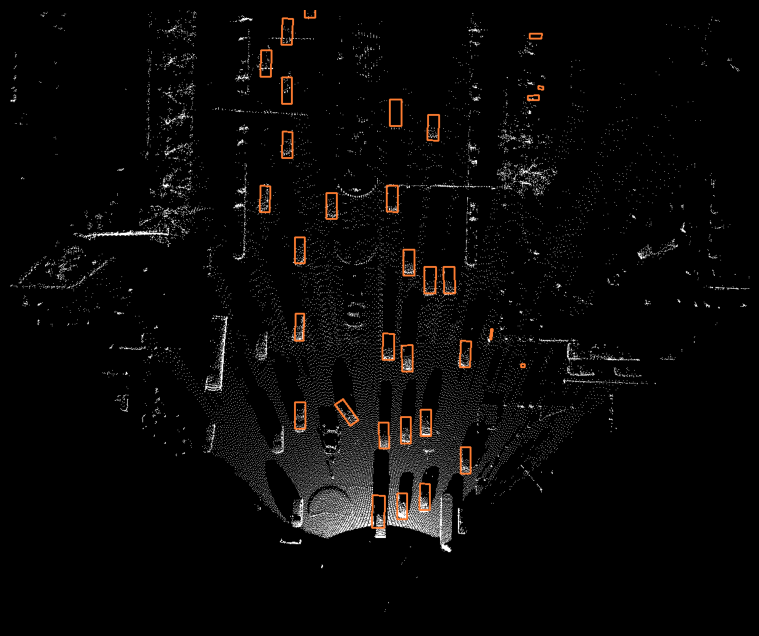

(1001, 1201)


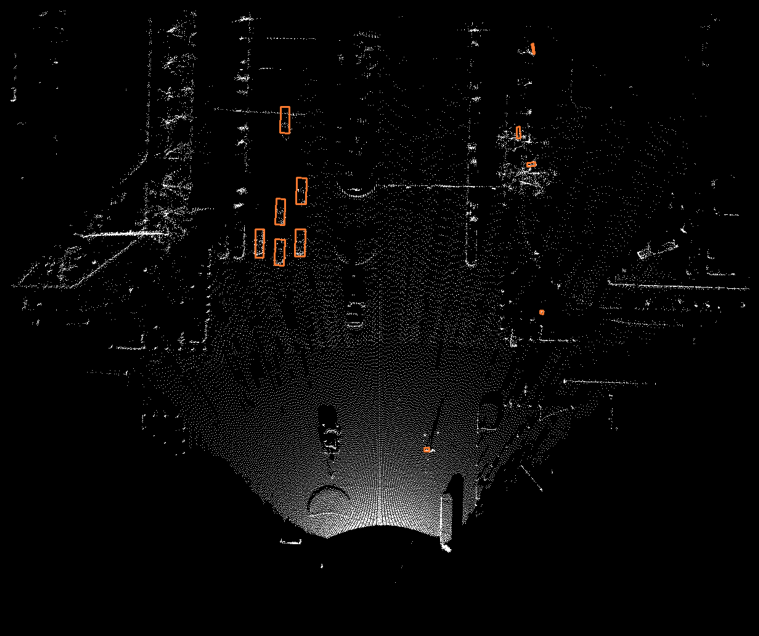

(1001, 1201)


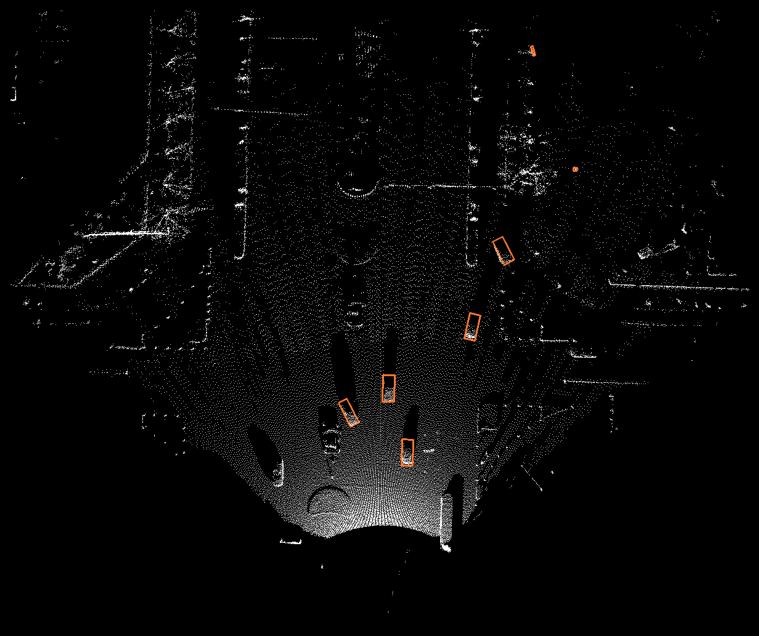

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

--------------------------------------------------------------------------------
,DATALOADER:0 TEST RESULTS
,{}
,--------------------------------------------------------------------------------


In [9]:
def main(args):
    if args.seed is not None:
        pl.seed_everything(args.seed)

    model = Pro3DLightningModel(**vars(args))

    checkpoint_path = args.ckpt_path
    if os.path.isdir(checkpoint_path):
        ckpt_files = [f for f in os.listdir(checkpoint_path) if f.endswith('.ckpt')]
        if not ckpt_files:
            raise FileNotFoundError(f"No .ckpt files in directory: {checkpoint_path}")
        checkpoint_path = os.path.join(checkpoint_path, sorted(ckpt_files)[-1])
        print(f"checkpoint: {checkpoint_path}")

    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        enable_progress_bar=True,
        logger=False
    )
    trainer.test(model, ckpt_path=checkpoint_path)

if __name__ == '__main__':
    main(infer_args)

## Cell 4: Visualize the results on Images with 3D Cuboids

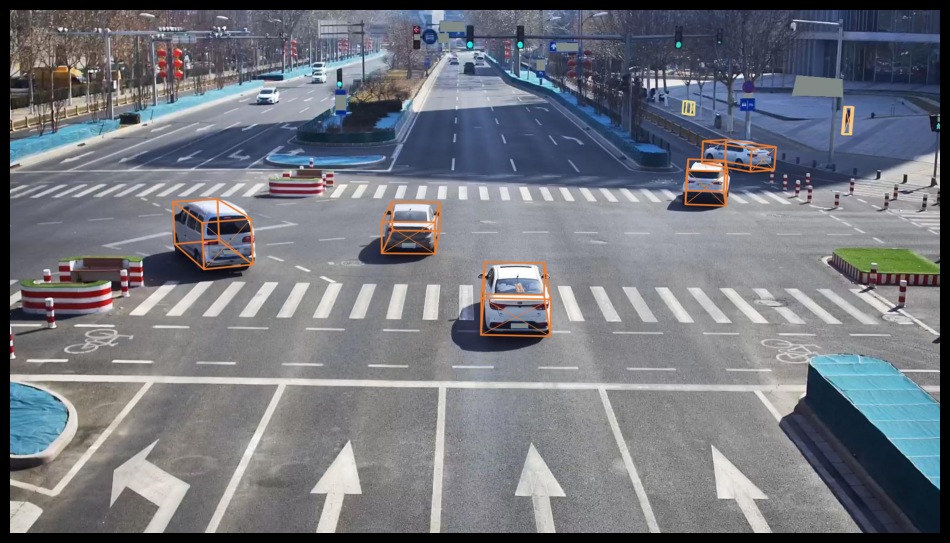

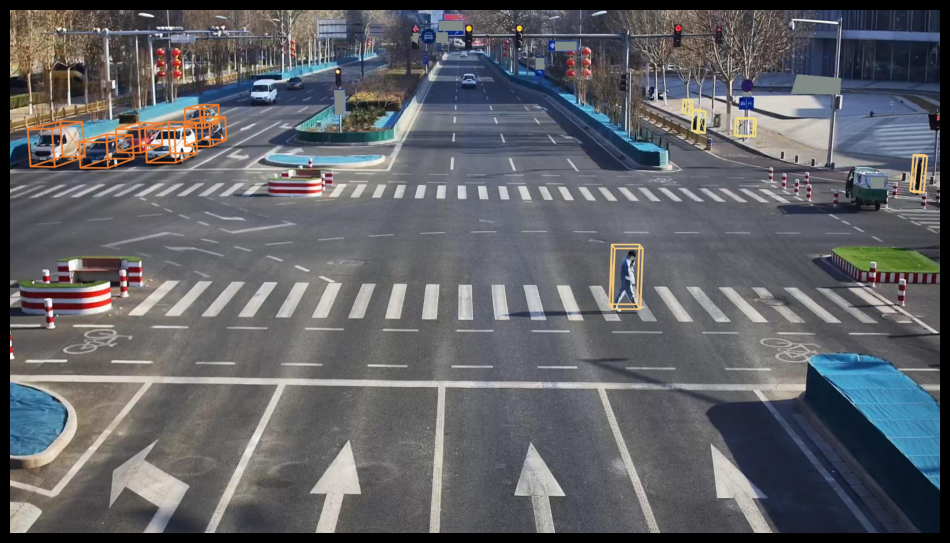

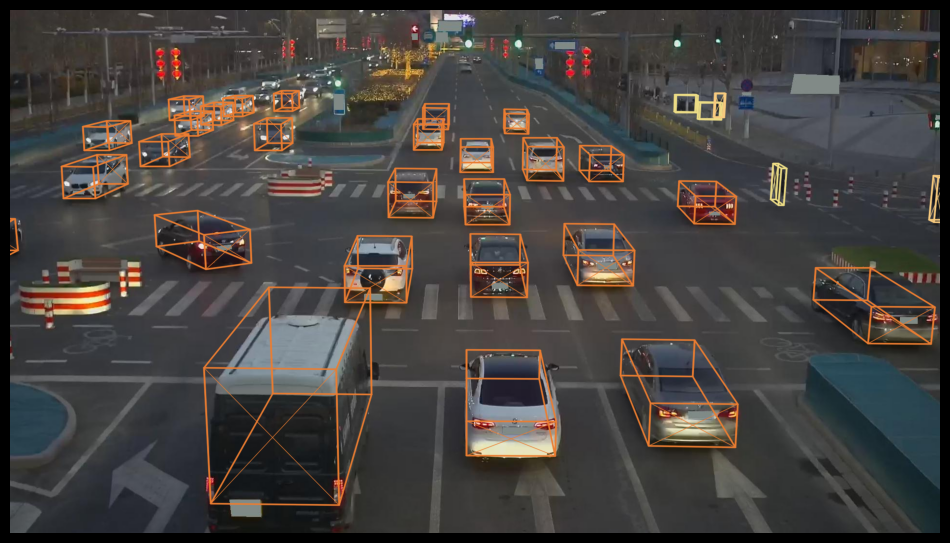

In [10]:
import os
import cv2

from scripts.data_converter.visual_utils import *

import warnings
warnings.filterwarnings("ignore")

def kitti_visual_tool(data_root):
    if not os.path.exists(data_root):
        raise ValueError("data_root Not Found")
    image_path = os.path.join(data_root, "training/image_2")
    calib_path = os.path.join(data_root, "training/calib")
    label_path = 'outputs/data'  # The directory where the inference result .txt files are located. Please ensure that there is a .txt file corresponding to each image in this directory.

    image_ids = []
    for image_file in os.listdir(label_path):
        image_ids.append(image_file.split(".")[0])
    for i in range(len(image_ids)):
        if os.path.exists(os.path.join(image_path, str(image_ids[i]) + ".png")):
            image_2_file = os.path.join(image_path, str(image_ids[i]) + ".png")
        elif os.path.exists(os.path.join(image_path, str(image_ids[i]) + ".jpg")):
            image_2_file = os.path.join(image_path, str(image_ids[i]) + ".jpg")
        else:
            print("Error: image file not found.")
            continue
        calib_file = os.path.join(calib_path, str(image_ids[i]) + ".txt")
        label_2_file = os.path.join(label_path, str(image_ids[i]) + ".txt")
        image = cv2.imread(image_2_file)
        if image is None:
            print(f"Warning: Could not read image {image_2_file}")
            continue
        _, P2, denorm = load_calib(calib_file)
        image = draw_3d_box_on_image(image, label_2_file, P2, denorm)

        # ---- Convert BGR (OpenCV default) to RGB for correct display in matplotlib and Jupyter ----
        visualized_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ---- Display using matplotlib ----
        plt.figure(figsize=(12, 8))
        plt.imshow(visualized_image_rgb)
        plt.axis('off')
        plt.show()

data_root = 'data/dair-v2x-i-kitti'
kitti_visual_tool(data_root)